Final A_sample:
 [[ 0.98651505  0.39144892]
 [-0.00195777 -1.00075178]]
Final B_sample:
 [[0.19845222]
 [0.50011945]]


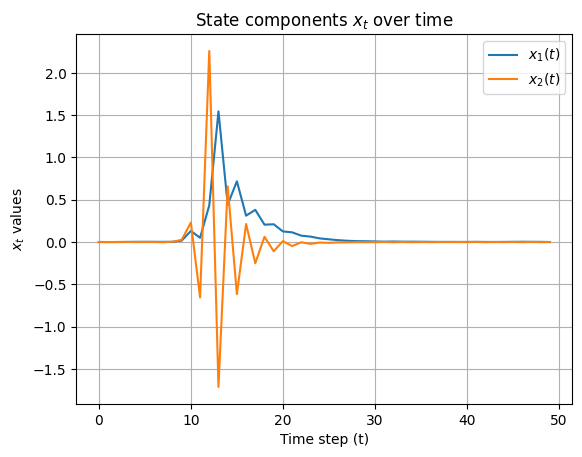

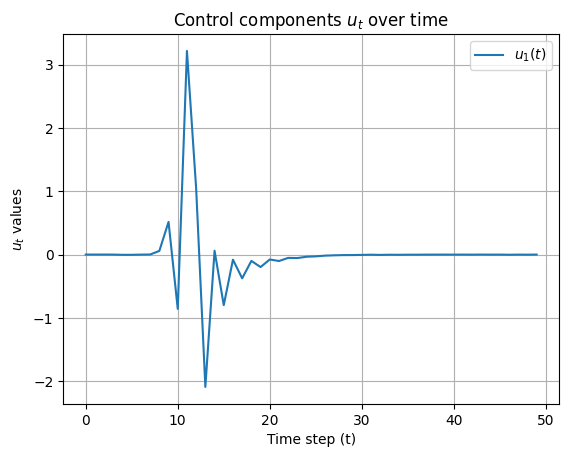

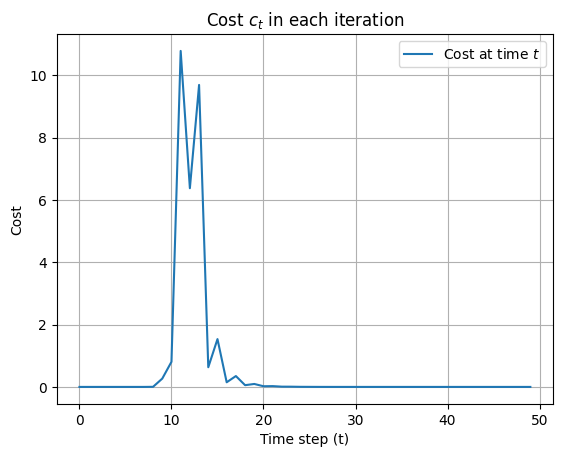

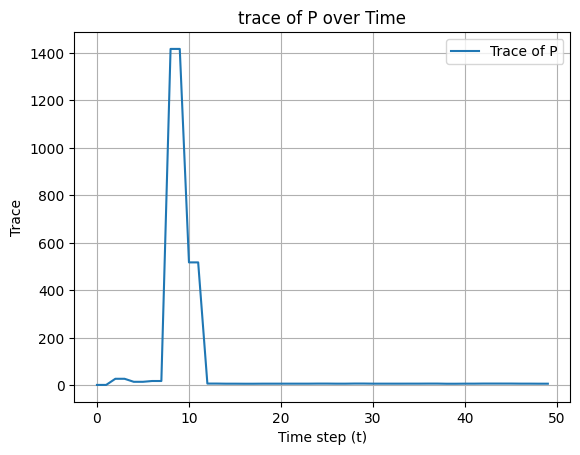

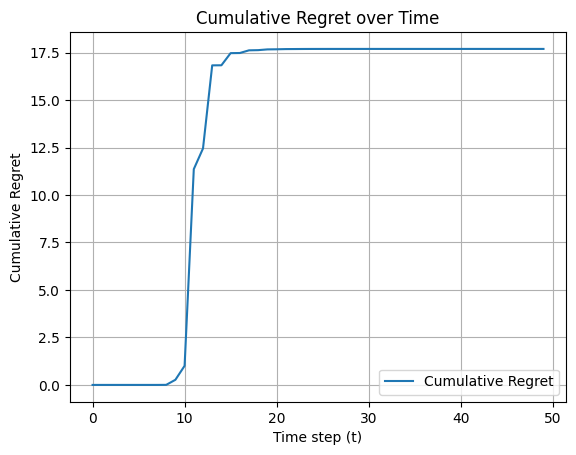

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from control import dare

class ThompsonSamplingLQR:
    def __init__(self, n, d, Q, R, delta, T, S, L, tau, epsilon=1e-5, alpha=1.0):
        """
        Initialize the Thompson Sampling for LQR problem.
        
        n: State dimension
        d: Control dimension
        Q: State cost matrix
        R: Control cost matrix
        T: Total time steps
        epsilon: Small value for regularization
        alpha: Exploration parameter
        tau: Maximum episode length
        """
        self.n = n
        self.d = d
        self.Q = Q
        self.R = R
        self.T = T
        self.epsilon = epsilon
        self.alpha = alpha
        self.tau = tau
        self.delta = delta
        self.S = S
        self.V = epsilon * np.eye(n + d)
        self.theta_hat = np.zeros((n+d, n))  # Correct shape for theta_hat
        self.t0 = 0
        self.L = L
        self.tau = tau
    def regularized_least_squares(self, Z, X):
        """
        Regularized least squares estimation.
        Z: Input data (stacked states and control inputs)
        X: Output data (next states)
        """
        V_t = Z.T @ Z + self.epsilon * np.eye(self.n + self.d)  # Add regularization term
        theta_hat = np.linalg.pinv(V_t) @ Z.T @ X  # Solve for theta_hat using least squares
        return theta_hat

    def compute_beta_t(self, V_t, lambda_reg, delta, n, L_s, S):
        """
        Compute the confidence bound beta_t.
        """
        det_V_t = np.linalg.det(V_t)
        det_lambda_I = np.linalg.det(lambda_reg * np.eye(V_t.shape[0]))
        log_term = 2 * np.log(det_V_t**0.5 / (det_lambda_I**0.5 * delta))
        first_term = n * L_s * np.sqrt(log_term)
        second_term = np.sqrt(lambda_reg) * S
        beta_t = (first_term + second_term)
        return beta_t
    
    def sample_theta(self, theta_hat, V_t):
        """
        Sample a perturbed parameter for Thompson Sampling.
        """
        beta = self.compute_beta_t(V_t, self.epsilon, self.delta / (8*T), self.n, self.L, self.S)
        try:
            regularized_V_t = V_t + self.epsilon * np.eye(V_t.shape[0])
            V_inv = np.linalg.inv(regularized_V_t)
            W_t = np.linalg.cholesky(V_inv).T
            eta_t = np.random.randn(self.n + self.d, self.n)
            perturbation = beta * W_t @ eta_t
            theta_sample = theta_hat + perturbation
            return theta_sample
        except np.linalg.LinAlgError as e:
            return theta_hat  # Fallback to the estimated parameters if sampling fails

    def compute_policy_gain(self, A, B):
        try:
            self.P, L, G = dare(A, B, self.Q, self.R)
            K_tilde = -np.linalg.inv(self.R + B.T @ self.P @ B) @ B.T @ self.P @ A
            return K_tilde
        except np.linalg.LinAlgError as e:
            print("Riccati equation failed. Using zero policy gain.")
            return np.zeros((self.d, self.n))

    def simulate_dynamics(self, A, B, x_t, u_t):
        """
        Simulate the system dynamics with noise.
        """
        noise = np.random.randn(self.n) * 0.001  # Add some noise to the state dynamics
        return A @ x_t + B @ u_t + noise
        
    def run(self, A_true, B_true):
        """
        Run the Thompson Sampling LQR algorithm.
        """
        x_t = np.zeros((self.n, 1))  # Initialize state
        regret = []
        cumulative_regret = 0
        costs = []
        u_t_values = []
        x_t_values = [x_t.flatten()]

        theta_sample = self.theta_hat  # Initialize with the estimated parameters
        V_t = self.V
        dataset_z_t = []  # To store z_t
        dataset_x_t1 = []
        tp = []
        for t in range(self.T):
            # Check the conditions for sampling
            condition_met = (t - self.t0 > self.tau or np.linalg.det(V_t) > 2 * np.linalg.det(self.V))
            if condition_met:
                theta_sample = self.sample_theta(self.theta_hat, self.V)
                self.t0 = t
                self.V = V_t

            # Extract A_sample and B_sample from theta_sample
            A_sample = theta_sample[:self.n, :].T  # A needs to be (n x n)
            B_sample = theta_sample[self.n:, :].T  # B needs to be (n x d)

            # Control action
            u_t = self.compute_policy_gain(A_sample, B_sample) @ x_t
            u_t_values.append(u_t.flatten())

            # Simulate dynamics
            x_t1 = self.simulate_dynamics(A_true, B_true, x_t.flatten(), u_t.flatten())
            x_t_values.append(x_t1)

            # Update dataset with current state and control
            z_t = np.hstack([x_t.flatten(), u_t.flatten()])
            dataset_z_t.append(z_t.T)
            dataset_x_t1.append(x_t1.T)
            
            Z = np.vstack(dataset_z_t)  # (T, n+d)
            X = np.vstack(dataset_x_t1)  # (T, n)

            # Update theta_hat using regularized least squares
            self.theta_hat = self.regularized_least_squares(Z, X)

            # Update the covariance matrix V_t
            V_t += np.outer(z_t, z_t)
            
            # Calculate cost
            cost_t = x_t.T @ self.Q @ x_t + u_t.T @ self.R @ u_t
            costs.append(cost_t.item())

            # Update regret
            optimal_cost_t =x_t.T@self.Q@x_t  # Optimal cost if known (can be from true model)
            regret_t = cost_t - optimal_cost_t  # Actual cost - optimal cost
            cumulative_regret += regret_t.item()
            regret.append(cumulative_regret)
            #trace of p
            trp = np.trace(self.P)
            tp.append(trp)

            # Update the state
            x_t = x_t1.reshape(-1, 1)

        return A_sample, B_sample, u_t_values, x_t_values, costs, regret,tp

# Example usage
n = 2  # State dimension
d = 1  # Control dimension
T = 50 # Time steps
delta = 0.1
S = 1
L = 0.001
tau = 1
# True system matrices (unknown to the learner)
A_true = np.array([[1.0, 0.40], [0.005, -0.99]])
B_true = np.array([[0.2], [0.5]])

# Cost matrices
Q = np.eye(n)
R = np.eye(d)

# Initialize and run Thompson Sampling LQR
ts_lqr = ThompsonSamplingLQR(n, d, Q, R, delta, T, S, L, tau)
A_sample, B_sample, u_t_values, x_t_values, costs, regret, tp = ts_lqr.run(A_true, B_true)

# Plotting control actions over time
time_steps = np.arange(T)
u_t_values = np.array(u_t_values)
x_t_values = np.array(x_t_values)
costs = np.array(costs)
regret = np.array(regret)
tp = np.array(tp)


# Print the final A_sample and B_sample
print("Final A_sample:\n", A_sample)
print("Final B_sample:\n", B_sample)


# Plot state components over time
for i in range(n):
    plt.plot(time_steps, x_t_values[:-1, i], label=f"$x_{{{i+1}}}(t)$")
plt.title('State components $x_t$ over time')
plt.xlabel('Time step (t)')
plt.ylabel('$x_t$ values')
plt.legend()
plt.grid(True)
plt.show()

# Plot control actions over time
for i in range(d):
    plt.plot(time_steps, u_t_values[:, i], label=f"$u_{{{i+1}}}(t)$")
plt.title('Control components $u_t$ over time')
plt.xlabel('Time step (t)')
plt.ylabel('$u_t$ values')
plt.legend()
plt.grid(True)
plt.show()

# Plot costs over time
plt.plot(time_steps, costs, label="Cost at time $t$")
plt.title('Cost $c_t$ in each iteration')
plt.xlabel('Time step (t)')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()

# Plot trace of P over time
plt.plot(time_steps, tp, label="Trace of P")
plt.title('trace of P over Time')
plt.xlabel('Time step (t)')
plt.ylabel('Trace')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative regret over time
plt.plot(time_steps, regret, label="Cumulative Regret")
plt.title('Cumulative Regret over Time')
plt.xlabel('Time step (t)')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()



